# Engineering a training dataset
In this notebook we will create a dataset to train a regression model, and guess customer engagement with an uploaded recipe
We will follow our planning created from the first exploration of the data:


![table](../images/table-planning.jpg)


# We start shaping the MVP data


In [18]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline
import datetime
from tqdm import tqdm 

start using RAW_interactions to score the interactions per recipes. 

In [2]:
interactions = pd.read_csv("../data/RAW_interactions.csv")
interactions.head()

,user_id,recipe_id,date,rating,review
0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...
1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall..."
2,8937,44394,2002-12-01,4,This worked very well and is EASY. I used not...
3,126440,85009,2010-02-27,5,I made the Mexican topping and took it to bunk...
4,57222,85009,2011-10-01,5,"Made the cheddar bacon topping, adding a sprin..."


In [3]:
interactions.rename(columns = {'date':'interaction_date','recipe_id':'id'}, inplace = True)

In [4]:
interactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1132367 entries, 0 to 1132366
Data columns (total 5 columns):
 #   Column            Non-Null Count    Dtype 
---  ------            --------------    ----- 
 0   user_id           1132367 non-null  int64 
 1   id                1132367 non-null  int64 
 2   interaction_date  1132367 non-null  object
 3   rating            1132367 non-null  int64 
 4   review            1132198 non-null  object
dtypes: int64(3), object(2)
memory usage: 43.2+ MB


we need to use pandas_groupby to start calculating aggregations

In [5]:
recipes = pd.read_csv("../data/RAW_recipes.csv")
recipes.head()

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13
3,alouette potatoes,59389,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","['spreadable cheese with garlic and herbs', 'n...",11
4,amish tomato ketchup for canning,44061,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"['tomato juice', 'apple cider vinegar', 'sugar...",8


As the database covers up to end of 2018 interactions, we will use 2018-12-31 as the reference day, as if we were doing this analysis then. 

In [6]:
REF_DAY = datetime.datetime(2018, 12, 31, 0, 0)

Now I want to bring over the subitted day of each recipe into the interaction dataset. 

In [7]:
submission_table = recipes[['id','submitted','contributor_id']]
submission_table.head()

,id,submitted,contributor_id
0,137739,2005-09-16,47892
1,31490,2002-06-17,26278
2,112140,2005-02-25,196586
3,59389,2003-04-14,68585
4,44061,2002-10-25,41706


In [8]:
interactions = interactions.merge(submission_table, on='id')
interactions.head()

,user_id,id,interaction_date,rating,review,submitted,contributor_id
0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...,2002-09-21,1533
1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall...",2002-09-21,1533
2,8937,44394,2002-12-01,4,This worked very well and is EASY. I used not...,2002-10-27,56824
3,126440,85009,2010-02-27,5,I made the Mexican topping and took it to bunk...,2004-02-25,64342
4,57222,85009,2011-10-01,5,"Made the cheddar bacon topping, adding a sprin...",2004-02-25,64342


In [9]:
interactions['interaction_date'] = pd.to_datetime(interactions['interaction_date'])
interactions['submitted'] = pd.to_datetime(interactions['submitted'])

In [10]:
interactions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1132367 entries, 0 to 1132366
Data columns (total 7 columns):
 #   Column            Non-Null Count    Dtype         
---  ------            --------------    -----         
 0   user_id           1132367 non-null  int64         
 1   id                1132367 non-null  int64         
 2   interaction_date  1132367 non-null  datetime64[ns]
 3   rating            1132367 non-null  int64         
 4   review            1132198 non-null  object        
 5   submitted         1132367 non-null  datetime64[ns]
 6   contributor_id    1132367 non-null  int64         
dtypes: datetime64[ns](2), int64(4), object(1)
memory usage: 69.1+ MB


In [11]:
interactions['days_after_sub'] = [d.days for d in (interactions['interaction_date']-interactions['submitted'])]

In [12]:
interactions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1132367 entries, 0 to 1132366
Data columns (total 8 columns):
 #   Column            Non-Null Count    Dtype         
---  ------            --------------    -----         
 0   user_id           1132367 non-null  int64         
 1   id                1132367 non-null  int64         
 2   interaction_date  1132367 non-null  datetime64[ns]
 3   rating            1132367 non-null  int64         
 4   review            1132198 non-null  object        
 5   submitted         1132367 non-null  datetime64[ns]
 6   contributor_id    1132367 non-null  int64         
 7   days_after_sub    1132367 non-null  int64         
dtypes: datetime64[ns](2), int64(5), object(1)
memory usage: 77.8+ MB


In [13]:
interactions.head()

,user_id,id,interaction_date,rating,review,submitted,contributor_id,days_after_sub
0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...,2002-09-21,1533,149
1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall...",2002-09-21,1533,3378
2,8937,44394,2002-12-01,4,This worked very well and is EASY. I used not...,2002-10-27,56824,35
3,126440,85009,2010-02-27,5,I made the Mexican topping and took it to bunk...,2004-02-25,64342,2194
4,57222,85009,2011-10-01,5,"Made the cheddar bacon topping, adding a sprin...",2004-02-25,64342,2775


We will do the sentiment analysis now before calculating these aggregations 

In [14]:
from textblob import TextBlob

In [15]:
pol = lambda x: TextBlob(x).polarity

In [19]:
# this takes a while to go through the whole column
interactions['review_pol'] = [pol(str(rev)) for rev in tqdm(interactions['review'])]

100%|██████████| 1132367/1132367 [07:54<00:00, 2385.70it/s]


In [20]:
interactions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1132367 entries, 0 to 1132366
Data columns (total 9 columns):
 #   Column            Non-Null Count    Dtype         
---  ------            --------------    -----         
 0   user_id           1132367 non-null  int64         
 1   id                1132367 non-null  int64         
 2   interaction_date  1132367 non-null  datetime64[ns]
 3   rating            1132367 non-null  int64         
 4   review            1132198 non-null  object        
 5   submitted         1132367 non-null  datetime64[ns]
 6   contributor_id    1132367 non-null  int64         
 7   days_after_sub    1132367 non-null  int64         
 8   review_pol        1132367 non-null  float64       
dtypes: datetime64[ns](2), float64(1), int64(5), object(1)
memory usage: 86.4+ MB


<AxesSubplot:>

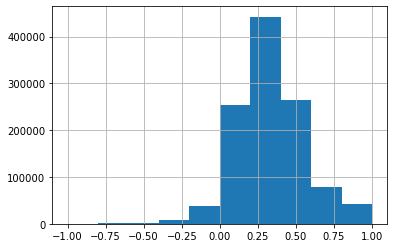

In [21]:
interactions.review_pol.hist()

In [22]:
interactions = interactions[['id',
                             'user_id',
                             'review',
                             'rating',
                             'interaction_date',
                             'submitted',
                             'contributor_id',
                             'days_after_sub',
                             'review_pol']]
interactions.head()

,id,user_id,review,rating,interaction_date,submitted,contributor_id,days_after_sub,review_pol
0,40893,38094,Great with a salad. Cooked on top of stove for...,4,2003-02-17,2002-09-21,1533,149,0.270000
1,40893,1293707,"So simple, so delicious! Great for chilly fall...",5,2011-12-21,2002-09-21,1533,3378,0.242857
2,44394,8937,This worked very well and is EASY. I used not...,4,2002-12-01,2002-10-27,56824,35,0.366667
3,85009,126440,I made the Mexican topping and took it to bunk...,5,2010-02-27,2004-02-25,64342,2194,0.350000
4,85009,57222,"Made the cheddar bacon topping, adding a sprin...",5,2011-10-01,2004-02-25,64342,2775,-0.208333


Save in a clean dataframe to be used later in tableau for more exploratory analysis

In [23]:
interactions.to_csv("../data/clean-data/interactions_clean.csv")

Now we calculate aggregations in order to enrich the recipe dataframe

In [24]:
interactions = pd.read_csv("../data/clean-data/interactions_clean.csv")

In [25]:
interaction_nums = interactions[['id','user_id','rating','days_after_sub','review_pol']]

In [26]:
interaction_nums

,id,user_id,rating,days_after_sub,review_pol
0,40893,38094,4,149,0.270000
1,40893,1293707,5,3378,0.242857
2,44394,8937,4,35,0.366667
3,85009,126440,5,2194,0.350000
4,85009,57222,5,2775,-0.208333
...,...,...,...,...,...
1132362,241491,417131,4,48,-0.184375
1132363,241491,648540,5,1145,0.277500
1132364,257796,1269180,4,1399,-0.127083
1132365,72730,116593,0,64,0.300000


We aggregate by RECIPE ID, to add parameters about user interaction to each recipe

In [27]:
interact_agg = interaction_nums.groupby('id').agg({'user_id':'count',
                                                   'rating':'mean',
                                                   'days_after_sub':['max','min','mean'],
                                                   'review_pol':'mean'})

We want to create new column names to flatten the 2 dimensional columns name 

In [28]:
 interact_agg.columns = ['_'.join(col).strip() for col in interact_agg.columns.values]

now we bring over the recipes 

In [29]:
recipes = pd.read_csv("../data/RAW_recipes.csv")
recipes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231637 entries, 0 to 231636
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   name            231636 non-null  object
 1   id              231637 non-null  int64 
 2   minutes         231637 non-null  int64 
 3   contributor_id  231637 non-null  int64 
 4   submitted       231637 non-null  object
 5   tags            231637 non-null  object
 6   nutrition       231637 non-null  object
 7   n_steps         231637 non-null  int64 
 8   steps           231637 non-null  object
 9   description     226658 non-null  object
 10  ingredients     231637 non-null  object
 11  n_ingredients   231637 non-null  int64 
dtypes: int64(5), object(7)
memory usage: 21.2+ MB


In [30]:
combined_df = pd.merge(recipes, interact_agg, how='left', on=['id'])

In [31]:
combined_df.head()

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients,user_id_count,rating_mean,days_after_sub_max,days_after_sub_min,days_after_sub_mean,review_pol_mean
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7,3,5.0,2271,155,1408.666667,0.333095
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6,4,3.5,3219,63,1850.500000,0.453839
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13,1,4.0,244,244,244.000000,0.569444
3,alouette potatoes,59389,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","['spreadable cheese with garlic and herbs', 'n...",11,2,4.5,2193,1885,2039.000000,0.444015
4,amish tomato ketchup for canning,44061,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"['tomato juice', 'apple cider vinegar', 'sugar...",8,1,5.0,3222,3222,3222.000000,0.285348


For the MVP we want to have a dataset with the following columns (descriptions are in the table at the top of this notebook): 

**recipe_id** (will be dropped before applying the model, we use it to track the recipe if we need to append things afterwards)  
**comm_rec_week** (dependant variable)  
**no_recipes_submitted**  
**avg_comments_recipes**  
**avg_ratings_recipes**  
**avg_sentiment_recipes**  
**time_to_cook**  
**no_steps**  
**no_ingredients**  
**nutrition_score**
**weekday_posted**
**month_posted**

In [32]:
combined_df['submitted'] = pd.to_datetime(combined_df['submitted'])

In [33]:
combined_df['days_since_posted'] = [d.days for d in REF_DAY - combined_df['submitted']]

In [34]:
combined_df['comm_rec_week'] = combined_df['user_id_count']/combined_df['days_since_posted']*30

For the columns coming from user data, we need to make some aggregations in the dataset

In [35]:
recipe_agg = combined_df.groupby('contributor_id').agg({'id':'count',
                                                        'user_id_count':'mean',
                                                        'rating_mean':'mean',
                                                        'review_pol_mean':'mean',
                                                        })

In [36]:
recipe_agg

,id,user_id_count,rating_mean,review_pol_mean
contributor_id,,,,
27,5,16.400000,3.879483,0.293479
1530,42,8.214286,4.186482,0.332973
1531,4,2.750000,4.775000,0.394319
1533,1595,3.554232,4.302731,0.321386
1534,297,6.353535,3.985190,0.324836
...,...,...,...,...
2002234364,1,1.000000,0.000000,-0.031181
2002234769,1,1.000000,0.000000,0.175000
2002247884,1,4.000000,0.000000,0.100608


In [37]:
recipe_agg.rename(columns = {'id':'no_recipes_submitted',
                             'user_id_count':'avg_comments_recipes',
                             'rating_mean':'avg_ratings_recipes',
                             'review_pol_mean':'avg_sentiment_recipes'
                            }, inplace = True)

In [38]:
recipe_agg

,no_recipes_submitted,avg_comments_recipes,avg_ratings_recipes,avg_sentiment_recipes
contributor_id,,,,
27,5,16.400000,3.879483,0.293479
1530,42,8.214286,4.186482,0.332973
1531,4,2.750000,4.775000,0.394319
1533,1595,3.554232,4.302731,0.321386
1534,297,6.353535,3.985190,0.324836
...,...,...,...,...
2002234364,1,1.000000,0.000000,-0.031181
2002234769,1,1.000000,0.000000,0.175000
2002247884,1,4.000000,0.000000,0.100608


In [39]:
combined_df = pd.merge(combined_df, recipe_agg, how='left', on=['contributor_id'])

In [41]:
combined_df

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,...,days_after_sub_max,days_after_sub_min,days_after_sub_mean,review_pol_mean,days_since_posted,comm_rec_week,no_recipes_submitted,avg_comments_recipes,avg_ratings_recipes,avg_sentiment_recipes
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,...,2271,155,1408.666667,0.333095,4854,0.018541,735,3.068027,4.596259,0.327186
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,...,3219,63,1850.500000,0.453839,6041,0.019864,366,5.669399,4.324293,0.320801
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,...,244,244,244.000000,0.569444,5057,0.005932,7,1.428571,4.714286,0.410158
3,alouette potatoes,59389,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...",...,2193,1885,2039.000000,0.444015,5740,0.010453,115,3.721739,4.369417,0.327694
4,amish tomato ketchup for canning,44061,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,...,3222,3222,3222.000000,0.285348,5911,0.005075,91,9.725275,4.375281,0.310879
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231632,zydeco soup,486161,60,227978,2012-08-29,"['ham', '60-minutes-or-less', 'time-to-make', ...","[415.2, 26.0, 34.0, 26.0, 44.0, 21.0, 15.0]",7,"['heat oil in a 4-quart dutch oven', 'add cele...",this is a delicious soup that i originally fou...,...,529,12,303.833333,0.249776,2315,0.077754,172,4.093023,4.677495,0.346470
231633,zydeco spice mix,493372,5,1500678,2013-01-09,"['15-minutes-or-less', 'time-to-make', 'course...","[14.8, 0.0, 2.0, 58.0, 1.0, 0.0, 1.0]",1,['mix all ingredients together thoroughly'],this spice mix will make your taste buds dance!,...,8,8,8.000000,-0.086061,2182,0.013749,1,1.000000,5.000000,-0.086061
231634,zydeco ya ya deviled eggs,308080,40,37779,2008-06-07,"['60-minutes-or-less', 'time-to-make', 'course...","[59.2, 6.0, 2.0, 3.0, 6.0, 5.0, 0.0]",7,"['in a bowl , combine the mashed yolks and may...","deviled eggs, cajun-style",...,494,124,416.000000,0.318391,3859,0.038870,2553,4.958480,4.440109,0.339765
231635,cookies by design cookies on a stick,298512,29,506822,2008-04-15,"['30-minutes-or-less', 'time-to-make', 'course...","[188.0, 11.0, 57.0, 11.0, 7.0, 21.0, 9.0]",9,['place melted butter in a large mixing bowl a...,"i've heard of the 'cookies by design' company,...",...,17,17,17.000000,0.151731,3912,0.007669,40,2.450000,4.176564,0.332633


# Steps after MVP
## Using spacy to find verbs in the steps and giving a difficulty 

Knowing our context is recipes, we expect to find a limited number of verbs that will describe different actions and techniques. we will see most common verbs we can find, and we will consider recipes with low or no verbs to be simpler than others that have more verbs into more complex recipes. 

In [40]:
import spacy
nlp = spacy.load("en_core_web_sm")

In [84]:
verbs_set = set()

In [95]:
for prep in tqdm(combined_df['steps'].sample(3000)):
    doc = nlp(prep)
    verbs = [token.text for token in doc if token.pos_=="VERB"]
    for verb in verbs:
        verbs_set.add(verb)
        


100%|██████████| 3000/3000 [00:48<00:00, 61.40it/s]


In [98]:
print(verbs_set)

{'return', 'oversoak', 'comgine', 'bacon', 'emulsify', 'smoothed', 'spilit', 'slicing', 'sandwiched', 'burn', 'avoid', 'knocking', 'chilled', 'weigh', 'flakes', 'uncover', 'scrap', 'turmeric', 'pureed', 'points', 'combines', 'carob', 'pinching', 'paper', 'serve-', 'protect', 'shredded', 'thumped', 'accepted', 'sauteeing', 'grate', 'allspice', 'spooned', 'encasing', 'bending', 'has', 'thumping', 'pay', 'stamp', 'liqueur', 'room', 'wish', 'detach', 'stack', 'think', 'extinguish', 'missed', 'eliminating', 'instruct', 'spluttering', 'jiggle', 'cutting', 'altered', 'poke', 'laughing', 'recipe', 'gathers', 'steeping', 'spoon', 'fluff', 'set', 'salt', 'shredding', 'bland', 'unsliced', 'dethawed', 'alow', 'tilting', 'swimming', 'pop', 'reaches', 'discolored', 'combined', 'decrease', 'snapping', 'shellfish', 'describe', 'let', 'organize', 'held', 'attain', 'equal', 'tossing', 'drains', 'bok', 'leaf', 'am', 'pitcher', 'overlay', 'lentils', 'marinating', 'rubbed', 'pile', 'thinning', 'cups', 'cle

This won't work without a more specific definition of what are verbs that correspond to cooking techniques in a kitchen. also spacy will detect several ingredient names as verbs, so we'll leave the complexity of the recipe to the column no_steps only and we will focus in creating categories with the tags. 

## Find all tags from all recipes and decide if we want to extract categories from them 

In [99]:
tags_set = set()
for tags in combined_df['tags'].sample(10):
        print (tags)

['weeknight', '15-minutes-or-less', 'time-to-make', 'course', 'main-ingredient', 'cuisine', 'preparation', 'occasion', 'north-american', 'for-1-or-2', '5-ingredients-or-less', 'beverages', 'fruit', 'vegetables', 'american', 'easy', 'vegan', 'vegetarian', 'smoothies', 'nuts', 'dietary', 'berries', 'brunch', 'number-of-servings', '3-steps-or-less']
['30-minutes-or-less', 'time-to-make', 'course', 'main-ingredient', 'preparation', 'occasion', 'for-1-or-2', '5-ingredients-or-less', 'appetizers', 'eggs-dairy', 'oven', 'easy', 'dinner-party', 'holiday-event', 'kid-friendly', 'romantic', 'dips', 'spreads', 'cheese', 'dietary', 'comfort-food', 'valentines-day', 'taste-mood', 'equipment', 'number-of-servings']
['60-minutes-or-less', 'time-to-make', 'course', 'main-ingredient', 'preparation', 'occasion', 'main-dish', 'beef', 'dinner-party', 'meat']
['time-to-make', 'course', 'cuisine', 'preparation', 'north-american', 'lunch', 'snacks', 'central-american', '4-hours-or-less']
['30-minutes-or-less

In [106]:
tags_set = set()

In [117]:
tags_set = set()
for row_tags in tqdm(combined_df['tags']):
    for tag in [a.strip("' ") for a in row_tags.strip("[]").split(",")]:
        tags_set.add(tag)

100%|██████████| 231637/231637 [00:01<00:00, 153146.90it/s]


In [118]:
len(tags_set)

552

In [119]:
tags_set

{'',
 '1-day-or-more',
 '15-minutes-or-less',
 '3-steps-or-less',
 '30-minutes-or-less',
 '4-hours-or-less',
 '5-ingredients-or-less',
 '60-minutes-or-less',
 'Throw the ultimate fiesta with this sopaipillas recipe from Food.com.',
 'a1-sauce',
 'african',
 'american',
 'amish-mennonite',
 'angolan',
 'appetizers',
 'apples',
 'april-fools-day',
 'argentine',
 'artichoke',
 'asian',
 'asparagus',
 'australian',
 'austrian',
 'avocado',
 'bacon',
 'baja',
 'baked-beans',
 'baking',
 'bananas',
 'bar-cookies',
 'barbecue',
 'bass',
 'bean-soup',
 'beans',
 'beans-side-dishes',
 'bear',
 'beef',
 'beef-barley-soup',
 'beef-crock-pot',
 'beef-kidney',
 'beef-liver',
 'beef-organ-meats',
 'beef-ribs',
 'beef-sauces',
 'beef-sausage',
 'beginner-cook',
 'beijing',
 'belgian',
 'berries',
 'beverages',
 'birthday',
 'biscotti',
 'bisques-cream-soups',
 'black-bean-soup',
 'black-beans',
 'blueberries',
 'bok-choys',
 'brazilian',
 'bread-machine',
 'bread-pudding',
 'breads',
 'breakfast',
 '

In [121]:
categories=['appetizers',
            'baking',
            'barbecue',
            'desserts',
            
            'breakfast',
            'brunch',
            'lunch',
            'cocktails',
            'dinner-party',
            
            'meat',
            'vegan',
            'vegetarian',
            
            'spicy',
            
            'low-carb',
            'low-fat',
            'low-protein',
            'low-sodium',
            'nut-free',
            'egg-free',
            'dairy-free',
            'gluten-free',
            
            'microwave',
            'easy',
            'no-cook',
            'deep-fry',
            
            'pasta',
            'pizza',
            'cupcakes',
            'muffins',
            'macaroni-and-cheese',
            
            'peanut-butter',
            'vegetables',
            'fruit',
            'bacon',
            'avocado',                       
            'cheese',
            'chocolate',
            ]

In [122]:
len(categories)

37

and we create a dataframe with dummies regarding these categories:

In [143]:
categories_df = pd.DataFrame(columns=categories)

In [144]:

for i,tags in tqdm(enumerate(combined_df['tags'])):
    row = []
    for cat in categories:
        if cat in tags:
            row.append(1)
        else:
            row.append(0)
    categories_df.loc[i] = row


231637it [1:46:18, 36.31it/s]


In [145]:
categories_df

,appetizers,baking,barbecue,desserts,breakfast,brunch,lunch,cocktails,dinner-party,meat,...,cupcakes,muffins,macaroni-and-cheese,peanut-butter,vegetables,fruit,bacon,avocado,cheese,chocolate
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,1,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231632,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
231633,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
231634,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
231635,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [147]:
combined_df = pd.concat([combined_df,categories_df], axis =1)

In [148]:
combined_df.to_csv("../data/clean-data/recipes_combined_clean.csv")

## Making a dataframe for the regression models 

In [ ]:
combined_df['weekday_posted'] = [d.weekday() for d in combined_df['submitted']]

In [ ]:
combined_df['month_posted'] = [d.month for d in combined_df['submitted']]

Now we need the columns from recipe. time_to_cook, no_steps and no_ingredients are already on the table, let's try to get a nutrition score, as well as the weekday and month on which the recipe was posted 

In [ ]:
combined_df.head()

In [ ]:
MVP_export = combined_df[['id',
                                    'comm_rec_week',
                                    'no_recipes_submitted',
                                    'avg_comments_recipes',
                                    'avg_ratings_recipes',
                                    'avg_sentiment_recipes',
                                    'minutes',
                                    'n_steps',
                                    'n_ingredients',
                                    'weekday_posted',
                                    'month_posted']]

In [ ]:
MVP_export.to_csv("../data/mvp_export.csv")